In [28]:
import pandas as pd
import yfinance as yf
from scipy.stats import linregress
import numpy as np
import os
from datetime import datetime, timedelta

def fetch_sp500_tickers():
    """Fetches the list of S&P 500 tickers."""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_list = pd.read_html(url)[0]
    return sp500_list['Symbol'].values.tolist()

def should_fetch_new_data(filepath):
    """Determines if new data should be fetched based on the last date in the file.
        First return value: True (update the data); False (Do not update data)
        Second return value: True (completely replace the existing data); False (Do not completely replace data)
    """
    should_update = False
    should_replace= False
    if not os.path.exists(filepath):
        should_replace = True
        return (should_update, should_replace)
    else:
        if os.path.getsize(filepath) == 0:
            should_replace = True
            return (should_update, should_replace)

        # file exist and is not empty, check the data
        existing_data = pd.read_csv(filepath, index_col='Date', parse_dates=['Date'])
        last_date = existing_data.index.max()

        # some invalid number in the file, completely replace the file
        if pd.isna(last_date):
            should_replace = True
            return (should_update, should_replace)

        # Ensure last_date is a datetime object (should be if coming from a pandas Timestamp)
        if isinstance(last_date, pd.Timestamp):
            # Convert to a "naive" datetime object, if it's not already
            last_date_naive = last_date.to_pydatetime().replace(tzinfo=None)
        else:
            last_date_naive = last_date

        # Check if the current date is more than 7 days from the last date in the file
        if datetime.now() - last_date_naive <= timedelta(days=7):
            should_update = False
            should_replace = False
            return (should_update, should_replace)  # No need to fetch new data

        should_update = True
        should_replace = False
        return (should_update, should_replace)  # File doesn't exist, is empty, or it's been more than 7 days

def fetch_and_save_weekly_stock_data(ticker, data_dir='../data/stock_data'):
    """Fetches historical weekly stock data and appends new data to the existing CSV file if needed."""
    filepath = os.path.join(data_dir, f"{ticker}_weekly.csv")
    should_update, should_replace = should_fetch_new_data(filepath)
    if should_replace:
        updated_data = yf.Ticker(ticker).history(period="5y", interval="1wk")
        updated_data.to_csv(filepath)
    elif should_update:
        # Load existing data
        existing_data = pd.read_csv(filepath, index_col='Date', parse_dates=True)
        last_date = existing_data.index.max()

        # Fetch new data starting from the day after the last date in the existing data
        new_data_start_date = last_date + pd.Timedelta(days=1)
        new_data = yf.Ticker(ticker).history(start=new_data_start_date.strftime('%Y-%m-%d'), interval="1wk")

        if not new_data.empty:
            # Append new data directly to the CSV, without reading the entire file into memory
            new_data.to_csv(filepath, mode='a', header=False)

        print(f"Fetching new data for {ticker}...")

def load_stock_data_into_memory(tickers, data_dir='../data/stock_data'):
    """
    Reads stock data for each ticker from CSV files and stores them in memory.

    Parameters:
    - tickers: List of ticker symbols.
    - data_dir: Directory where the stock data CSV files are stored.

    Returns:
    A dictionary where keys are ticker symbols and values are DataFrames of stock data.
    """
    stock_data = {}
    for ticker in tickers:
        filepath = os.path.join(data_dir, f"{ticker}_weekly.csv")
        if os.path.exists(filepath):
            stock_data[ticker] = pd.read_csv(filepath, index_col='Date', parse_dates=['Date'])
        else:
            print(f"Data for {ticker} not found in {data_dir}.")
    return stock_data

tickers = fetch_sp500_tickers()
for ticker in tickers:  # Example: Process only the first 5 tickers for demonstration
    fetch_and_save_weekly_stock_data(ticker)

stock_data = load_stock_data_into_memory(tickers)

BRK.B: No data found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (period=5y)


                                 Open        High         Low       Close  \
Date                                                                        
2019-02-04 00:00:00-05:00   41.907748   42.128507   40.412843   40.890350   
2019-02-11 00:00:00-05:00   41.219943   41.564545   40.786175   41.068123   
2019-02-18 00:00:00-05:00   40.897029   41.766974   40.844013   41.682629   
2019-02-25 00:00:00-05:00   41.969406   42.381483   41.624800   42.164600   
2019-03-04 00:00:00-05:00   42.338104   42.834526   40.846426   41.668175   
...                               ...         ...         ...         ...   
2024-01-08 00:00:00-05:00  182.089996  187.050003  181.500000  185.919998   
2024-01-15 00:00:00-05:00  182.160004  191.949997  180.300003  191.559998   
2024-01-22 00:00:00-05:00  192.300003  196.380005  191.940002  192.419998   
2024-01-29 00:00:00-05:00  192.009995  192.199997  179.250000  185.850006   
2024-02-05 00:00:00-05:00  188.149994  189.309998  185.839996  189.300003   

In [59]:
def calculate_30week_ma(ticker, stock_data, window=30):
    data = stock_data[ticker]

    # Calculate 30-week MA
    data['30_MA'] = data['Close'].rolling(window=window).mean()

    return data

# apple_stock = calculate_30week_ma('AAPL', stock_data)
# print(apple_stock)

def find_stocks_crossing_above_ma(stock_data_in_memory):
    """
    Identifies stocks whose price has just crossed above their 30-week MA.

    Parameters:
    - stock_data_in_memory: A dictionary with ticker symbols as keys and DataFrames as values.
      Each DataFrame should have at least 'Close' and '30_MA' columns.

    Returns:
    - crossing_stocks: A list of ticker symbols for stocks that have just crossed above their 30-week MA.
    """
    crossing_stocks = []
    for ticker, data in stock_data_in_memory.items():
        # Ensure there's enough data to check the condition
        if len(data) < 2 or 'Close' not in data.columns or '30_MA' not in data.columns:
            continue

        # Check if the latest close is above the 30_MA and the previous close was below the 30_MA
        if data['Close'].iloc[-1] > data['30_MA'].iloc[-1] and \
           data['Close'].iloc[-2] > data['30_MA'].iloc[-2] and \
           data['Close'].iloc[-3] < data['30_MA'].iloc[-3] and \
           data['Volume'].iloc[-2] > data['Volume'].iloc[-3]:


            crossing_stocks.append(ticker)

    return crossing_stocks

def find_stocks_volume_boost(stock_data_in_memory):
    """
    Identifies stocks whose price has just crossed above their 30-week MA.

    Parameters:
    - stock_data_in_memory: A dictionary with ticker symbols as keys and DataFrames as values.
      Each DataFrame should have at least 'Close' and '30_MA' columns.

    Returns:
    - crossing_stocks: A list of ticker symbols for stocks that have just crossed above their 30-week MA.
    """
    volume_boost_stocks = []
    for ticker, data in stock_data_in_memory.items():
        # Ensure there's enough data to check the condition
        if len(data) < 2 or 'Close' not in data.columns or '30_MA' not in data.columns:
            continue

        # past months' average volume
        # volume_avg_past_month = 0.25*(sum(data['Volume'].iloc[-5:-1]))
        volume_avg_past_month =   data['Volume'].iloc[-2]

        for i in range(-3,0):
        # Check if the latest close is above the 30_MA and the previous close was below the 30_MA
            if data['Volume'].iloc[i] > 3*data['Volume'].iloc[i-1] and \
            data['Close'].iloc[i] > data['Open'].iloc[i]:
                volume_boost_stocks.append(ticker)

    return volume_boost_stocks

# calculate 30 week MA for all the stocks
for ticker in stock_data:
    _ = calculate_30week_ma(ticker, stock_data)

breakouts = find_stocks_crossing_above_ma(stock_data)
print(breakouts)

volume_boosts = find_stocks_volume_boost(stock_data)
print(volume_boosts)

['ADP', 'CTVA', 'DG', 'DTE', 'EW', 'ETSY', 'F', 'LOW', 'NCLH', 'ODFL', 'PARA', 'PEP', 'STE', 'WST']
['NFLX', 'WDC']


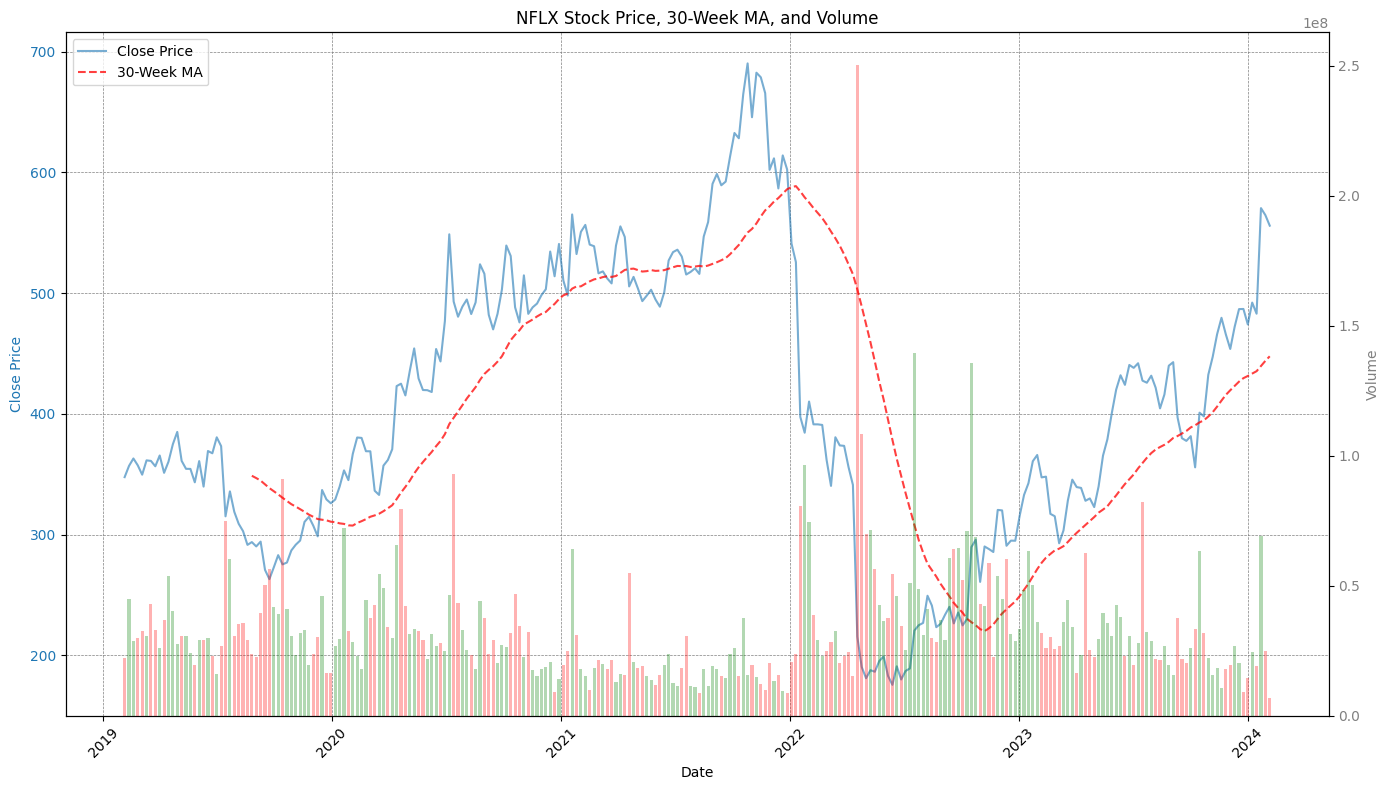

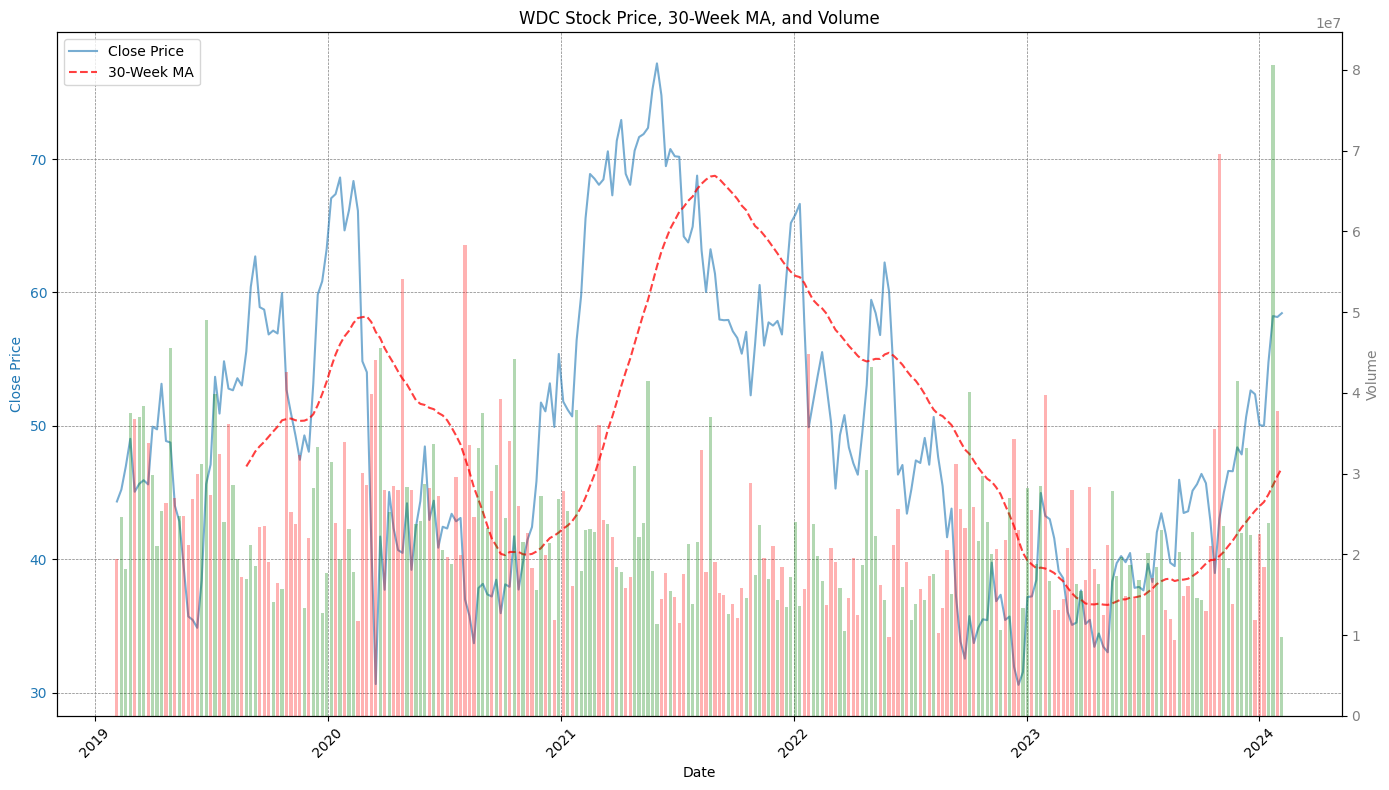

In [60]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_stock_price_ma_and_volume(df, ticker):
    # Create a figure and a grid of subplots
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Plotting the closing price and 30-week MA
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(df.index, df['Close'], label='Close Price', color=color, alpha=0.6)
    ax1.plot(df.index, df['30_MA'], label='30-Week MA', color='red', linestyle='--', alpha=0.75)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')

    # Instantiate a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Volume', color='grey')

    # Iterate over each day to color the volume bars
    for index, row in df.iterrows():
        if row['Close'] > row['Open']:  # Close is higher than open
            ax2.bar(index, row['Volume'], color='green', alpha=0.3, width=5)
        else:  # Close is lower or equal to open
            ax2.bar(index, row['Volume'], color='red', alpha=0.3, width=5)

    ax2.tick_params(axis='y', labelcolor='grey')

    # Setting the major locator for x-axis (date)
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Rotating the date labels to improve readability
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    plt.title(f"{ticker} Stock Price, 30-Week MA, and Volume")
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

# Example usage
# Make sure df is your DataFrame containing the stock data for a particular ticker
# For instance, if you have AAPL's stock data in df:
# plot_stock_price_ma_and_volume(apple_stock, "AAPL")
for ticker in volume_boosts:
    plot_stock_price_ma_and_volume(stock_data[ticker],ticker)

In [18]:


def calculate_slope(series, slope_window):
    """Calculates the slope of the MA series using linear regression for the last 30 values."""
    print(series)
    print(slope_window)
    y = series.dropna().values[-slope_window:]  # Use only the last 4 non-NA values
    print(y)
    x = np.arange(len(y))
    slope, intercept, _, _, _ = linregress(x, y)
    return slope

def calculate_normalized_slop(ticker, slope_window=4):
    """Fetch the normalized ma data and find the slope."""
    data = calculate_and_save_normalized_ma(ticker)
    # print(data)

    # Calculate the slope of the MA
    slope = calculate_slope(data['Normalized_30_MA'],slope_window)

    return slope

def process_stocks(tickers):
    """Processes stocks to fetch data, calculate MA, save both, and determine slopes for ranking."""
    stock_slopes = []
    for ticker in tickers:
        slope = calculate_normalized_slop(ticker)
        stock_slopes.append((ticker, slope))
    # Sort and select top 10 stocks based on the absolute value of their slope
    top_stocks_by_slope = sorted(stock_slopes, key=lambda x: abs(x[1]), reverse=True)[:10]
    return top_stocks_by_slope

# Execution
sp500_tickers = fetch_sp500_tickers()
top_stocks_by_slope = process_stocks(["AAPL"])

# Output the top 10 stocks with the steepest MA slopes
for stock, slope in top_stocks_by_slope:
    print(f"Ticker: {stock}, MA Slope: {slope}")


Date
2019-01-28 00:00:00-05:00         NaN
2019-02-04 00:00:00-05:00         NaN
2019-02-11 00:00:00-05:00         NaN
2019-02-18 00:00:00-05:00         NaN
2019-02-25 00:00:00-05:00         NaN
                               ...   
2024-01-01 00:00:00-05:00    0.998757
2024-01-08 00:00:00-05:00    0.999027
2024-01-15 00:00:00-05:00    1.000000
2024-01-22 00:00:00-05:00    0.999813
2024-01-29 00:00:00-05:00    0.999214
Name: Normalized_30_MA, Length: 262, dtype: float64
4
[0.99902723 1.         0.99981302 0.99921378]
Ticker: AAPL, MA Slope: 3.726810782218592e-05


In [3]:
print(len(stage_2_stocks))

257
